# Doughnut seminar 2023: Introduction to Stan

M D Blackledge

If you would like to run this notebook through collab, then please use the following link:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdblackledge/stan_examples/blob/main/notebooks/doughnut_seminar_2023.ipynb)

## Library installation
First we need to check that all relevant libraries are installed into the Jupyter instance.  Be cautious when installing this on an M1/M2 chip on the Mac.  This should work on a Linux machine or Google colab.

In [1]:
!pip install pystan arviz | grep -v 'already satisfied'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 51.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 7.3 MB/s eta 0:00:00


## Library Import

Import all relevant libraries.  Note that for Stan to work in Jupyter, we also need nest_asyncio!

In [2]:
import nest_asyncio
nest_asyncio.apply()
import httpstan
import stan
import arviz as az

import numpy as np
import matplotlib.pyplot as plt

## Example 1. Basic usage
In this example we will create a very simple model to demonstrate how to estimate the mean and standard deviation from $N=40$ data sampled from a normal distribution:
$$
x_{i} \sim \mathcal{N}(\mu, \sigma)
$$
with $\mu=2$ and $\sigma=3$.

In general, Stan code consist of a minimum of three code blocks (in order):

```
// Comments are written using double forward-slash convention
data {
    
}
parameters {

}
model {

}
```

In [3]:
simple_model = """
data {
    int<lower = 1> N;
    array[N] real x;
}
parameters {
    real mu;
    real<lower = 0> sigma;
}
model {
    for (n in 1:N) {
        target += normal_lpdf(x[n] | mu, sigma);
    }
}
"""

# Synthesize some data
N = 40
x = np.random.normal(loc = 2.0, scale = 3.0, size = N)

# Build the model.  This will take some time the first time it is run!
model = stan.build(simple_model, data = {"N": N, "x": x})

# Draw some samples
samples = model.sample(num_samples = 5000,  # How many samples to we want?
                       num_warmup = 500,  # How many samples to discard from the beginning?
                       num_chains = 2,  # How many indpendent sample chains do we want? At least 2 for diagnostics!
                       num_thin = 1)  # Do we want to reduce correlations?

Building...



Building: 32.5s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  50% (5500/11000)
Sampling: 100% (11000/11000)
Sampling: 100% (11000/11000), done.
Messages received during sampling:
  Gradient evaluation took 2.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.3 seconds.
  Adjust your expectations accordingly!


## A brief interlude: ArviZ

ArviZ is a power vizualisation library for illustration of Stan fitting results (and other MCMC packages!).  The best way to get started is to use the example gallery for ideas: https://python.arviz.org/en/stable/examples/index.html.

Here we will use ArviZ to:

1. Obtain a better representation of the sampled data
2. Plot the sample traces to visualize whether they are adequate.
3. Display a summary of the the fit, including convergence diagnostic $\widehat{R}$.

### Convert to ArviZ data
ArviZ converts the output pystan samples into something it can use via the `az.from_pystan` function.  The result is an instance of a `Numba` Python package variable, which provides better access to samples from individual chains.

In [4]:
# Convert pystan samples into something arviz can deal with
az_samples = az.from_pystan(samples)
az_samples

Inference data with groups:
	> posterior
	> sample_stats

### Plotting sample traces
It is crucial to investigate the sample traces of your parameters, ideally from 2 or more chains to check that

1. The samples are not correlated.
2. Samples have converged from initial parameter guesses.
3. There is good mixing between chains.

ArviZ provides a basic plotting utility, `az.plot_trace`, that can be used to visualize samples.

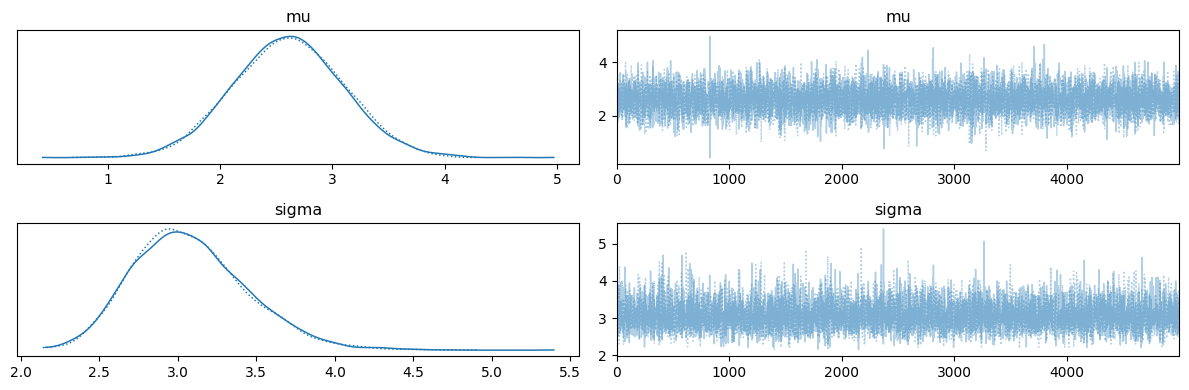

In [8]:
# Display the traces for each chain
az.plot_trace(az_samples)

plt.tight_layout()  # Hint: This always improves layout of results
plt.show()

### Assessing convergence numerically
A summary of the samples can be obtained using the `az.summary` function, which includes calcaultion of `r_hat`, a number indicating the quality of mixing from data from 2 or more chains.  It is calculated by comparing the variance of the samples within each chain to the variance of the pooled samples across chains.  A value of `r_hat` < 1.05 is normally acceptable, though I have been stricter (<1.01).

In [6]:
# How good are the convergence diagnostics?
az.summary(az_samples)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,2.606,0.494,1.689,3.536,0.006,0.004,7815.0,5903.0,1.0
sigma,3.076,0.368,2.428,3.764,0.004,0.003,7067.0,6252.0,1.0


## Example dataset
In the following, we use an existing dataset from a previous paper (https://pubmed.ncbi.nlm.nih.gov/34341730/), which explores the difference in ADC statistics between diseased and helthy nodes, as assessed using whole-body DWI.

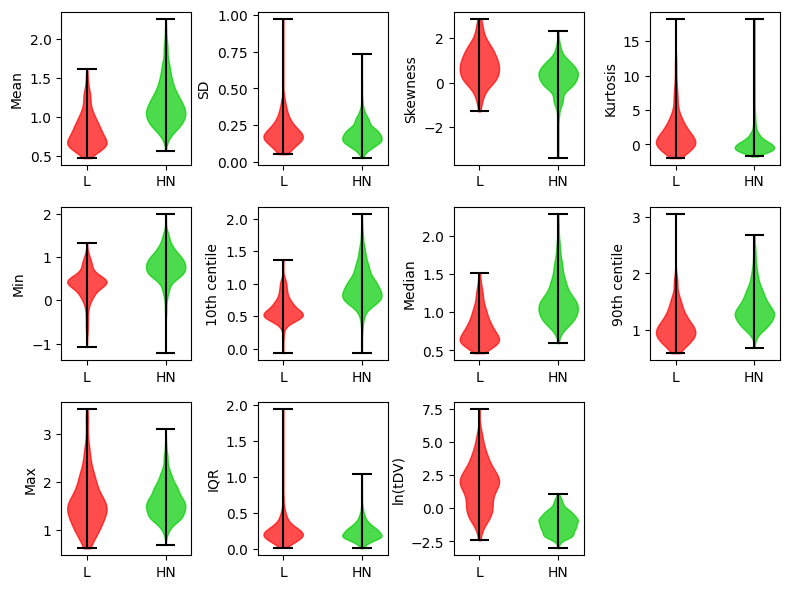

In [16]:
import pandas as pd
df_nodes = pd.read_csv("https://raw.githubusercontent.com/mdblackledge/stan_examples/main/notebooks/resources/nodes.csv")
df_disease = pd.read_csv("https://raw.githubusercontent.com/mdblackledge/stan_examples/main/notebooks/resources/lymphoma.csv")

_, ax = plt.subplots(3, 4, figsize = (8, 6))
ax = ax.ravel()

for idx, metric in enumerate(["Mean", "SD", "Skewness", "Kurtosis", "Min",
                              "10th centile", "Median", "90th centile", "Max",
                              "IQR", "ln(tDV)"]):

    vals_nodes = np.array(df_nodes[metric])
    vals_disease = np.array(df_disease[metric])

    violins = ax[idx].violinplot([vals_disease, vals_nodes])
    violins["bodies"][0].set_color([1, 0, 0])
    violins["bodies"][1].set_color([0, 0.8, 0])
    violins["bodies"][0].set_alpha(0.7)
    violins["bodies"][1].set_alpha(0.7)
    violins["cbars"].set_color("k")
    violins["cmins"].set_color("k")
    violins["cmaxes"].set_color("k")
    ax[idx].set_xticks([1, 2], ["L", "HN"])
    ax[idx].set_ylabel(metric)

ax[-1].axis("off")
plt.tight_layout()
plt.show()

## Significant difference in ADC medians
We would like to know whether there is a significant difference in the Median ADC between healthy and diseased nodes. Conventionally, this would be done using a 2-sample t-test with unequal variance, where the following test statsitics are derived, and p-value subsequently calcaulted from the correct Student t-distribution.
$$
t_{df} = \frac{\overline{x_{1}} - \overline{x_{2}}}{\sqrt{\frac{S_{1}^{2}}{N_{1}} + \frac{S_{2}^{2}}{N_{2}}}} \qquad df=\frac{\left(\frac{S_{1}^{2}}{N_{1}} + \frac{S_{2}^{2}}{N_{2}}\right)^{2}}{\frac{\left(\frac{S_{1}^{2}}{N_{1}}\right)^{2}}{N_{1}-1} + \frac{\left(\frac{S_{2}^{2}}{N_{2}}\right)^{2}}{N_{2}-1}}
$$
where $S_{i} = $ sample standard deviation, $\overline{x_{i}} = $ sample mean.

In [26]:
from scipy.stats import ttest_ind

metric = "Mean"
values_nodes = np.array(df_nodes[metric])
values_disease = np.array(df_disease[metric])
pvalue = ttest_ind(values_nodes, values_disease, equal_var=False).pvalue
print(f"{metric} p-value = {pvalue}")

Mean p-value = 2.739022504713298e-54


But what is this really comparing? What we are really after is the likely difference in the means of the the distributions for healthy versus disease nodes.  In the following we explicitly specify the model we are assuming for this data and ask it to provide us with the posterior distribution on the differences of the means.

In [39]:
two_sample_unequal_var_model = """
data {
    int<lower=1> N1;
    int<lower=1> N2;
    array[N1] real x1;
    array[N2] real x2;
}
parameters {
    real mu1;
    real mu2;
    real<lower = 0> sigma1;
    real<lower = 0> sigma2;
}
transformed parameters {
    real mud;
    mud = mu2 - mu1;
}
model {
    // Priors
    mu1 ~ normal(0, 10);
    mu2 ~ normal(0, 10);
    sigma1 ~ cauchy(0, 5);
    sigma2 ~ cauchy(0, 5);

    // Likelihood
    x1 ~ normal(mu1, sigma1);
    x2 ~ normal(mu2, sigma2);
}
"""

metric = "IQR"
values_nodes = np.array(df_nodes[metric])
values_disease = np.array(df_disease[metric])

model = stan.build(two_sample_unequal_var_model,
                   data = {"N1": len(values_nodes),
                           "N2": len(values_disease),
                           "x1": values_nodes,
                           "x2": values_disease})
samples = model.sample(num_samples = 5000,
                       num_chains = 3,
                       num_thin = 1,
                       num_warmup = 500)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:  33% (5500/16500)
Sampling:  67% (11000/16500)
Sampling: 100% (16500/16500)
Sampling: 100% (16500/16500), done.
Messages received during sampling:
  Gradient evaluation took 1.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.19 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_03qj83fi/model_cea42les.stan', line 27, column 4 to column 29)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds

Next we will investigate the ArviZ trace plots of the mean difference and the summary statistics.

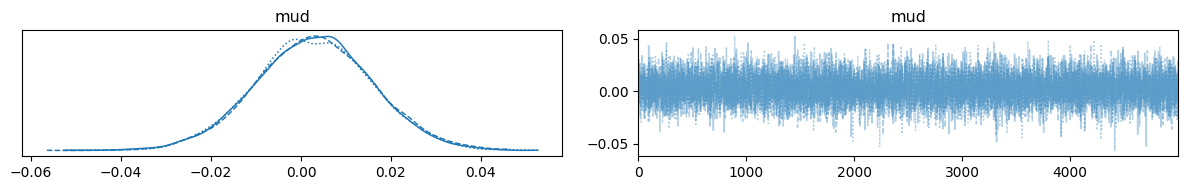

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.246,0.004,0.239,0.253,0.0,0.0,20671.0,11979.0,1.0
mu2,0.249,0.013,0.225,0.272,0.0,0.0,14837.0,10917.0,1.0
sigma1,0.121,0.003,0.116,0.126,0.0,0.0,13246.0,10495.0,1.0
sigma2,0.175,0.009,0.159,0.193,0.0,0.0,14097.0,9707.0,1.0
mud,0.003,0.013,-0.022,0.028,0.0,0.0,15018.0,11135.0,1.0


In [40]:
az_samples = az.from_pystan(samples)
az.plot_trace(az_samples, var_names=["mud"])
plt.tight_layout()
plt.show()

az.summary(az_samples)

It is also possible to just plot the posterior density, including a "Region of Practical Equivalence".  This is somewhat similar to a non-inferiority test in traditional statistics and allows one to accept the Null-hypothesis (if siffucient data are available).

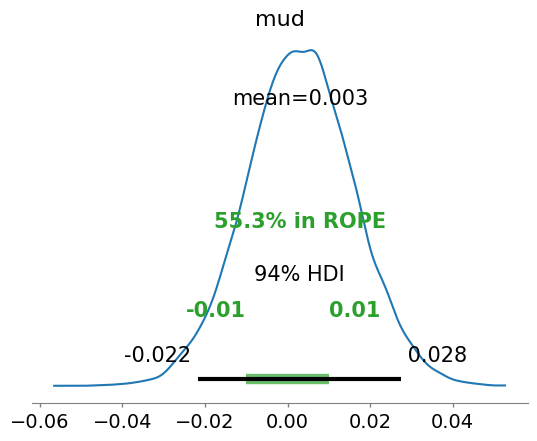

In [41]:
az.plot_posterior(az_samples, var_names=["mud"], rope=[-0.01, 0.01])
plt.show()

## Linear correlation
We may like to know whether there is a linear correlation between ADC median and ADC 10th percentile.

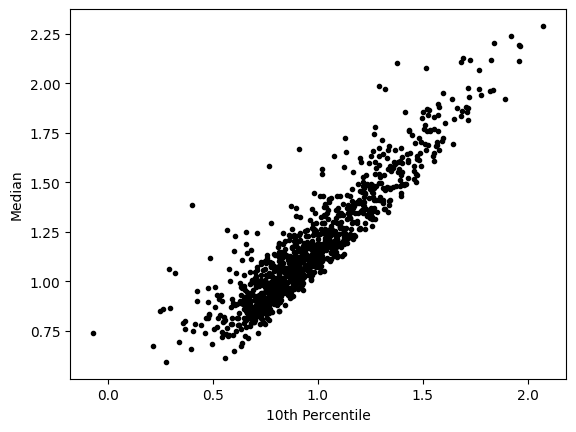

In [49]:
medians =  df_nodes["Median"]
perc_10 =  df_nodes["10th centile"]
plt.plot(perc_10, medians, "k.")
plt.xlabel("10th Percentile"), plt.ylabel("Median")
plt.show()

This can be easily coded in Stan for determination of relevant model parameters.

In [56]:
linear_model = """
data {
    int<lower = 1> N;
    array[N] real x;
    array[N] real y;

    int<lower = 1> N_pred;
    array[N_pred] real x_pred;
}
parameters {
    real slope;
    real intercept;
    real <lower = 0> sigma;
}
model {
    // Priors
    slope ~ normal(0, 10);
    intercept ~ normal(0, 10);
    sigma ~ cauchy(0, 5);

    // Likelihood
    for (n in 1:N)
        y[n] ~ normal(slope * x[n] + intercept, sigma);
}
generated quantities {
    // Posterior predictive
    array[N_pred] real y_pred;
    for (n in 1:N_pred)
        y_pred[n] = normal_rng(slope * x_pred[n] + intercept, sigma);
}
"""

medians =  np.array(df_nodes["Median"])
perc_10 =  np.array(df_nodes["10th centile"])

N_pred = 100
x_pred = np.linspace(perc_10.min(), perc_10.max(), N_pred)
model = stan.build(linear_model, data = {"N": len(medians),
                                         "x": perc_10,
                                         "y": medians,
                                         "N_pred": N_pred,
                                         "x_pred": x_pred})
samples = model.sample(num_samples = 3000,
                       num_chains = 3,
                       num_warmup = 500,
                       num_thin = 1)

Building...



Building: 37.5s, done.Sampling:   0%
Sampling:   0% (1/10500)
Sampling:   0% (2/10500)
Sampling:   1% (101/10500)
Sampling:   2% (200/10500)
Sampling:   3% (300/10500)
Sampling:   4% (400/10500)
Sampling:   5% (500/10500)
Sampling:   6% (600/10500)
Sampling:   7% (700/10500)
Sampling:   8% (800/10500)
Sampling:  11% (1200/10500)
Sampling:  41% (4300/10500)
Sampling:  70% (7400/10500)
Sampling: 100% (10500/10500)
Sampling: 100% (10500/10500), done.
Messages received during sampling:
  Gradient evaluation took 0.000396 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.96 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000297 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.97 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be posit

Let's take a look at the traces

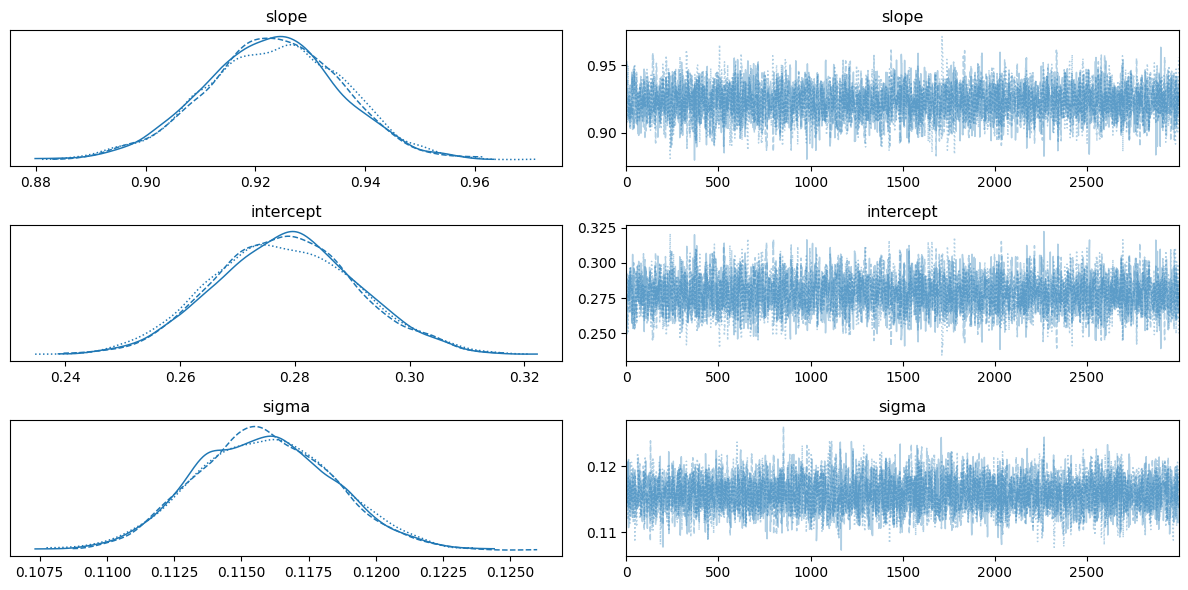

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,0.923,0.013,0.900,0.947,0.000,0.000,3520.0,3520.0,1.0
intercept,0.278,0.013,0.256,0.304,0.000,0.000,3580.0,3489.0,1.0
sigma,0.116,0.003,0.111,0.121,0.000,0.000,4026.0,4305.0,1.0
y_pred[0],0.212,0.116,-0.000,0.439,0.001,0.001,8954.0,8892.0,1.0
y_pred[1],0.229,0.117,0.009,0.450,0.001,0.001,8638.0,8419.0,1.0
...,...,...,...,...,...,...,...,...,...
y_pred[95],2.114,0.118,1.896,2.332,0.001,0.001,8834.0,8948.0,1.0
y_pred[96],2.134,0.118,1.921,2.361,0.001,0.001,8236.0,8797.0,1.0
y_pred[97],2.155,0.118,1.939,2.378,0.001,0.001,8736.0,8860.0,1.0
y_pred[98],2.173,0.118,1.949,2.392,0.001,0.001,8171.0,8757.0,1.0


In [57]:
az_samples = az.from_pystan(samples)
az.plot_trace(az_samples, var_names = ["slope", "intercept", "sigma"])
plt.tight_layout()
plt.show()

az.summary(az_samples)

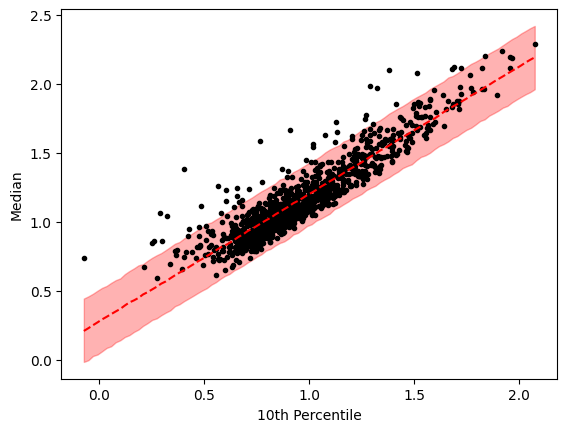

In [60]:
y_pred_perc_2p5 = np.percentile(samples["y_pred"], 2.5, axis = 1)
y_pred_perc_50 = np.percentile(samples["y_pred"], 50, axis = 1)
y_pred_perc_97p5 = np.percentile(samples["y_pred"], 97.5, axis = 1)

plt.plot(perc_10, medians, "k.")
plt.plot(x_pred, y_pred_perc_50, "r--")
plt.fill_between(x_pred, y_pred_perc_2p5, y_pred_perc_97p5, color = "r", alpha = 0.3)
plt.xlabel("10th Percentile"), plt.ylabel("Median")
plt.show()